In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.autolayout"] = True

In [40]:
# Load dataset.
dftrain = pd.read_csv('Data/Titanic Dataset/eval.csv') # training data
dfeval = pd.read_csv('Data/Titanic Dataset/eval.csv') # testing data


In [41]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [42]:
dftrain.pop("parch")
dfeval.pop("parch")
dftrain.pop("embark_town")
dfeval.pop("embark_town")

y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


In [43]:
dftrain.describe()

,age,n_siblings_spouses,fare
count,264.000000,264.000000,264.000000
mean,28.720985,0.469697,27.023880
std,14.157538,0.978393,34.973108
min,0.420000,0.000000,0.000000
25%,21.000000,0.000000,7.925000
50%,28.000000,0.000000,13.250000
75%,35.250000,1.000000,27.900000
max,74.000000,8.000000,263.000000


In [44]:
dftrain.shape

(264, 7)

<Axes: >

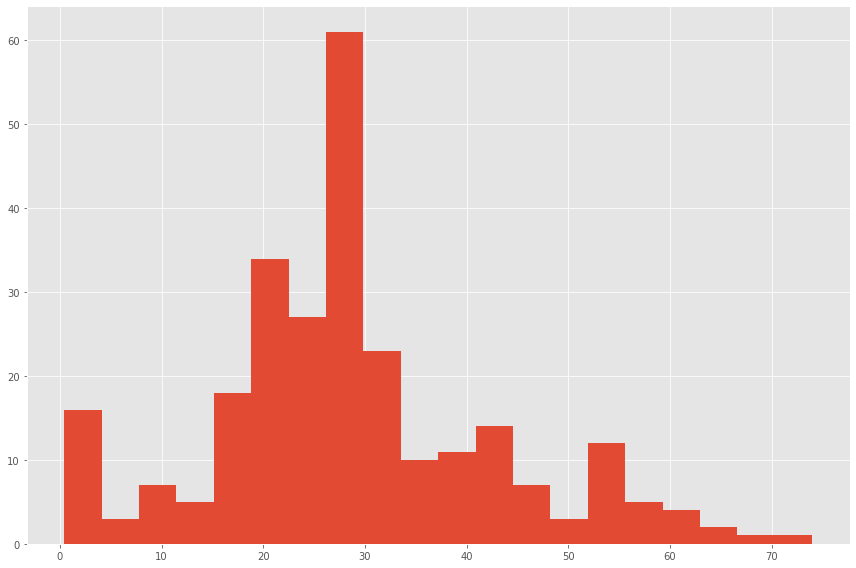

In [45]:
dftrain.age.hist(bins=20)

<Axes: >

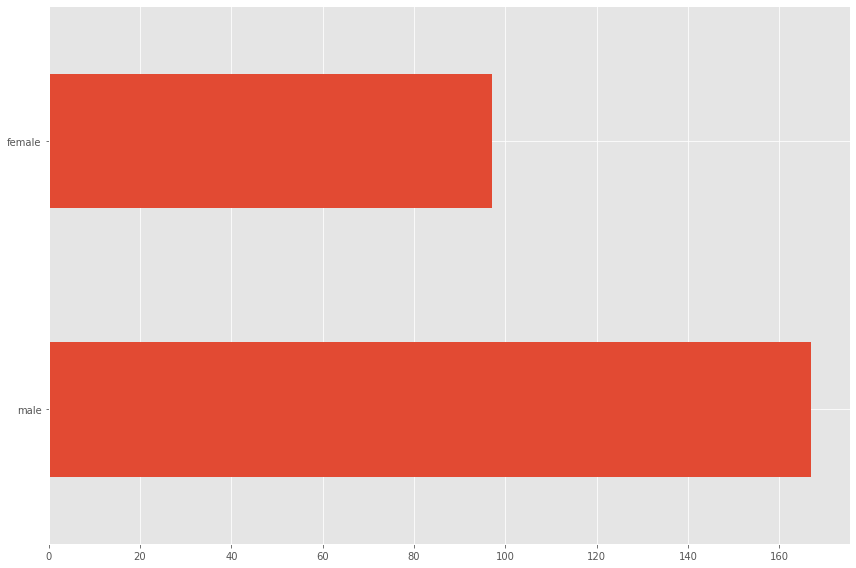

In [46]:
dftrain.sex.value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

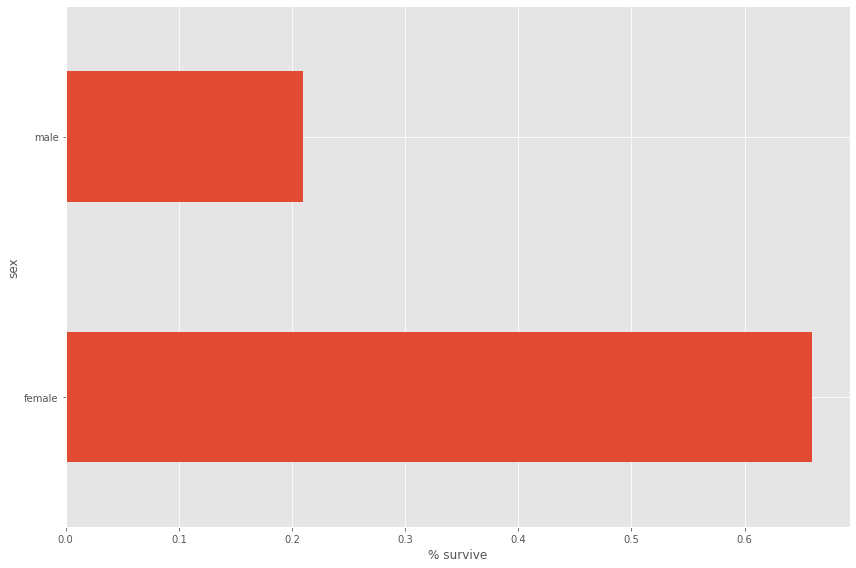

In [47]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [48]:
categorical_column =['sex', 'n_siblings_spouses', 'class', 'deck','alone']

numeric_columns = ['age', 'fare']

feature_columns = []

#converting categorical data into numeric data 
for feature_name in categorical_column:
    vocabulary = dftrain[feature_name].unique() #gets a list of all unique values from given feature
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [49]:
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(0, 3, 2, 1, 5, 4, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'E', 'C', 'D', 'F', 'B', 'A'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0), NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [50]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)




In [51]:
#Creating Model
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7462121


In [52]:
print(eval_input_fn)


<function make_input_fn.<locals>.input_function at 0x12e830c10>


In [53]:
pred_dicts = list(linear_est.predict(eval_input_fn)) # Making list of all the predictions

print(len(pred_dicts))
print(pred_dicts)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/x_/ydljc2zn6z30j2fhr27cbr4h0000gn/T/tmpi8pz7tg2/model.ckpt-90
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-04-27 14:45:53.904395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [264]
	 [[{{node Placeholder/_4}}]]


264
[{'logits': array([-2.2569523], dtype=float32), 'logistic': array([0.09475146], dtype=float32), 'probabilities': array([0.90524846, 0.09475145], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-1.8414081], dtype=float32), 'logistic': array([0.13688485], dtype=float32), 'probabilities': array([0.86311513, 0.13688484], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.0597515], dtype=float32), 'logistic': array([0.48506656], dtype=float32), 'probabilities': array([0.51493347, 0.4850666 ], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.0731368], d

In [54]:
print(pred_dicts[0]["probabilities"][1]) #Probability of Survival obtained from the model for person in index 0
print(y_eval.loc[0]) # Actual Survival Information
print(dfeval.loc[0]) # Predicted chances of death

0.094751455
0
sex                      male
age                      35.0
n_siblings_spouses          0
fare                     8.05
class                   Third
deck                  unknown
alone                       y
Name: 0, dtype: object
